# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые уже перешли на тарифы «Смарт» или «Ультра». По каждому клиенту имеется следующая информация по поведению за месяц: количество звонков, суммарная длительность звонков в минутах, количество sms-сообщений, израсходованный интернет-трафик в Мб, каким тарифом пользовался в течение месяца. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработку данных мы сделали ранее в другом проекте. Необходимо построить модель с максимально большим значением «accuracy», но не менее 75%.

План работы:
- Изучение общей информации по данным о клиентах, проверка на наличие аномальных значений, проверка распределения целевого признака, проверка корреляции между признаками.
- Разделение исходных данных на обучающую и тестовую выборки
- Поиск наилучшей модели с подбором гиперпараметров
- Проверка моделей на тестовой выборке
- Проверка моделей на вменяемость
- Общий вывод

## Подготовка

### Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
pd.options.display.max_colwidth = 100

viewing_jpg = True
if viewing_jpg:
    import plotly.io as pio
    jpg_renderer = pio.renderers['jpg']
    pio.renderers.default='jpg'
    jpg_renderer.width = 950
    jpg_renderer.height = 550

### Подготовка необходимых функций

In [2]:
# Разделение на признаки и цель
def features_target(data):
    return data.drop('is_ultra', axis=1), data.is_ultra


# Проверка влияния столбцов с сильной корреляцией между собой на правильность ответов
def calls_or_minures(tr_x, tr_y, te_x, te_y):
    for dep in range(2, 11, 2):
        model = DecisionTreeClassifier(random_state = 12345, max_depth = dep)
        model.fit(tr_x, tr_y)
        answers = model.predict(te_x)
        accuracy = accuracy_score(te_y, answers)
        print('Максимальная глубина дерева = {} |'.format(dep),\
              'Доля правильных ответов = {:.2%}'.format(accuracy))


# Выбор оптимальных параметров
def best_param(cls, param, algorithm, name):
    best_model = GridSearchCV(cls, param, cv=5)
    best_model.fit(train_x, train_y)
    optimal_parameters = best_model.best_params_
    time = round(best_model.refit_time_, 5)
    best_score = (best_model.best_score_ * 100).round(2)
    temp = [algorithm, name, best_score, None, optimal_parameters, time]
    temp = pd.DataFrame(data=[temp], columns=['Модель', 'Алгоритм', 'Правильность, %',\
                                              'Итоговая правильность, %', 'Оптимальные параметры',\
                                              'Скорость, cек.'])
    return temp


# Проверка количества тарифов в выборке
def sanity(tp, titl):
    test_pred = tp
    plt.pie(np.unique(test_pred, return_counts=True)[1],\
            labels=np.unique(test_pred, return_counts=True)[0],\
            labeldistance=0.8, pctdistance=0.2, autopct='%1.0f%%', radius=2.1,\
            wedgeprops = { 'linewidth' : 1.5, 'edgecolor' : 'white' })
    plt.title('Количество тарифов в выборке, модель - ' + titl, pad=90)
    plt.show()

## Изучение общей информации

Сохраним таблицу в переменную "df" и выведем первые 5 строк

In [3]:
try:
    df = pd.read_csv('/datasets/users_behavior.csv')
except:
    df = pd.read_csv(r'C:\Users\Admiral\Desktop\учеба\практикум\Проекты\Datasets\05_users_behavior.csv')

display(df.head())

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


На первый взгляд все впорядке. Изучим основные статистические показатели по таблице

In [4]:
display(df.describe())

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Аномальные значения не обнаружены. Изучим общую информацию по таблице

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Пропусков не обнаружено, тип данных почти везде подходящий. Для экономии памяти заменим тип данных в столбцах "calls", "messages" и "is_ultra" на uint8

In [6]:
df[['calls', 'messages', 'is_ultra']] = df[['calls', 'messages', 'is_ultra']].astype('uint8')

Проверим соотношение тарифов в выборке

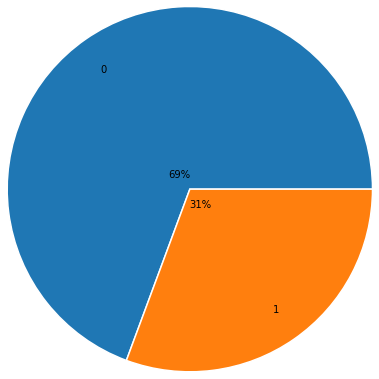

In [7]:
plt.pie(df.groupby('is_ultra')['calls'].count().reset_index().calls, \
        labels=df.groupby('is_ultra')['calls'].count().reset_index().is_ultra,\
        labeldistance=0.8, pctdistance=0.1, autopct='%1.0f%%', radius=2.1,\
        wedgeprops = { 'linewidth' : 1.5, 'edgecolor' : 'white' })
plt.show()

Клиенты в зависимости от тарифа распределены не равномерно. Большая часть клиентов, а именно 69%, пользуются тарифом Smart, остальные 31% пользователи тарифа Ultra. Нужно будет учесть это при разделении выборки на обучающую и тестовую.

Проверим корреляцию между признаками

<AxesSubplot:>

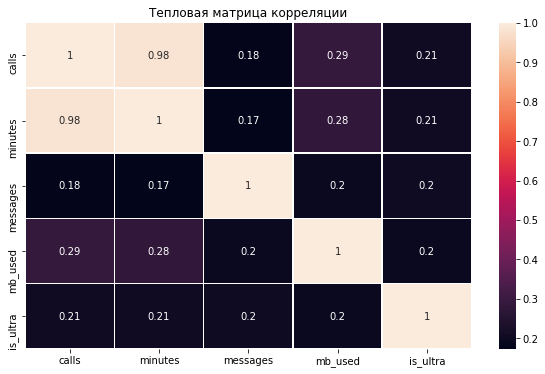

In [8]:
plt.figure(figsize=(10, 6))
display(sns.heatmap(df.corr(), annot=True, linewidths=.5))
plt.title('Тепловая матрица корреляции')
plt.show()

Чрезвычайно высокая корреляция достигается между минутами разговора и количеством звонков. Для наглядности проверим зависимость между этими признаками на графике.

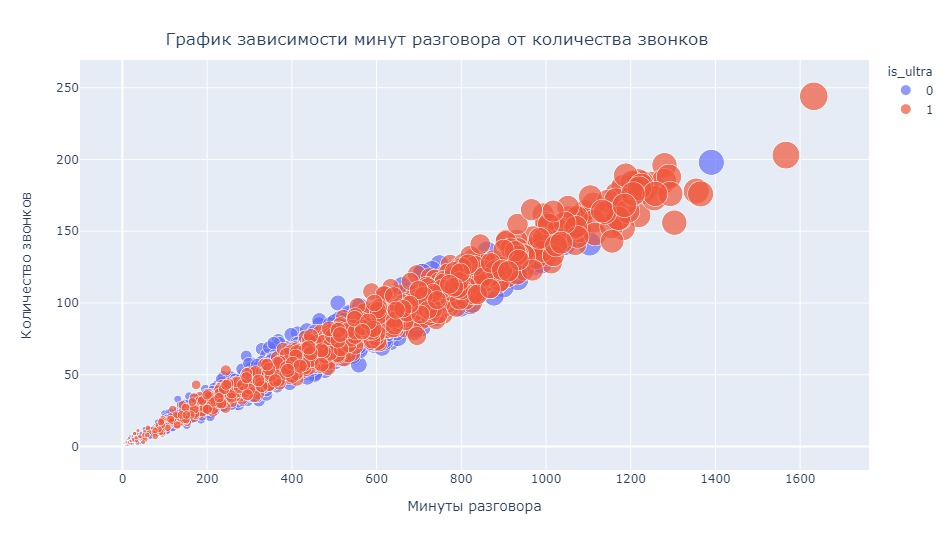

In [9]:
fig = px.scatter(df, x='minutes', y='calls', color='is_ultra', size='minutes',\
                 labels=dict(minutes='Минуты разговора', calls='Количество звонков'))
fig.update_layout(title={'text': 'График зависимости минут разговора от количества звонков',\
                         'y':0.94, 'x':0.46})
fig.show()

График так-же подтверждает зависимсоть между этими параметрами. Использование обоих параметров в обучении модели может привести к переобучению а так-же к увеличению времени предсказания. Проведем эксперимент, проверим правильность предсказаний в трех вариантах: с обоими признаками, без признака количества звонков, без признака количества минут разговора. Для начала сохраним копию таблицы в отдельную переменную.

In [10]:
df_temp = df.copy()

Разделим данные на тестовую и обучающую выборки. Параметру "stratify" в качестве значения передадим столбец "is_ultra" для сохранения пропорций пользователей.

In [11]:
df_temp_train, df_temp_test = train_test_split(df, test_size=0.25,\
                                     random_state=271828, stratify=df.is_ultra)

Проверим долю правильных ответов с использованием обоих признаков на модели на основе алгоритма "Дерево решений" с 5 различными показателями максимальной глубины дерева.

In [12]:
temp_train_x, temp_train_y = features_target(df_temp_train)
temp_test_x, temp_test_y = features_target(df_temp_test)
calls_or_minures(temp_train_x, temp_train_y, temp_test_x, temp_test_y)

Максимальная глубина дерева = 2 | Доля правильных ответов = 78.73%
Максимальная глубина дерева = 4 | Доля правильных ответов = 78.86%
Максимальная глубина дерева = 6 | Доля правильных ответов = 79.98%
Максимальная глубина дерева = 8 | Доля правильных ответов = 79.10%
Максимальная глубина дерева = 10 | Доля правильных ответов = 79.60%


Проверим долю правильных ответов без использования признака количества звонков на модели на основе алгоритма "Дерево решений" с 5 различными показателями максимальной глубины дерева.

In [13]:
temp_train_x, temp_train_y = features_target(df_temp_train.drop('calls', axis=1))
temp_test_x, temp_test_y = features_target(df_temp_test.drop('calls', axis=1))
calls_or_minures(temp_train_x, temp_train_y, temp_test_x, temp_test_y)

Максимальная глубина дерева = 2 | Доля правильных ответов = 78.73%
Максимальная глубина дерева = 4 | Доля правильных ответов = 78.73%
Максимальная глубина дерева = 6 | Доля правильных ответов = 79.73%
Максимальная глубина дерева = 8 | Доля правильных ответов = 80.10%
Максимальная глубина дерева = 10 | Доля правильных ответов = 79.48%


Проверим долю правильных ответов без использования признака количества минут разговора на модели на основе алгоритма "Дерево решений" с 5 различными показателями максимальной глубины дерева.

In [14]:
temp_train_x, temp_train_y = features_target(df_temp_train.drop('minutes', axis=1))
temp_test_x, temp_test_y = features_target(df_temp_test.drop('minutes', axis=1))
calls_or_minures(temp_train_x, temp_train_y, temp_test_x, temp_test_y)

Максимальная глубина дерева = 2 | Доля правильных ответов = 78.36%
Максимальная глубина дерева = 4 | Доля правильных ответов = 79.35%
Максимальная глубина дерева = 6 | Доля правильных ответов = 80.10%
Максимальная глубина дерева = 8 | Доля правильных ответов = 80.97%
Максимальная глубина дерева = 10 | Доля правильных ответов = 80.72%


Максимальная доля правильных ответов достигается при ограничении максимальной глубины дерева равное 8. При такой глубине дерева что с использованием обоих признаков, что без использования одного из них, доля правильных ответов почти неизменна, а значит для существенного увеличения скорости предсказания мы можем убрать один из признаков. Так как доля правильных ответов все же чуть лучше без использования признака количества минут разговора, удалим из данных этот признак.

In [15]:
df = df.drop('minutes', axis=1)

## Разделение данных на обучающую и тестовую выборки

Разделим данные на обучающую и тествую выборки. Отдельно выделять валидационную выборку не будем, так как подбор параметров будем производить при помощи кросс-валидации. Так же в связи с разным количеством рассматриваемых тарифов в выборке, параметру "stratify" передадим столбец "is_ultra"

In [16]:
df_train, df_test = train_test_split(df, test_size=0.25,\
                                     random_state=271828, stratify=df.is_ultra)

Проверим размеры выборок

In [17]:
print(df_train.shape, df_test.shape)

(2410, 4) (804, 4)


Сохраним в отдельные переменные для каждой выборки признаки и цель

In [18]:
train_x, train_y = features_target(df_train)
test_x, test_y = features_target(df_test)

## Исследование моделей

### Обучение модели на основе алгоритма классификации "Классификатор дерева решений"

Для выбора лучшей модели используем разные вариации гиперпараметров:
- Минимальное число объектов в листе: от 1 до 7
- Максимальная глубина дерева: от 1 до 9 с шагом 2
- Число признаков для выбора расщепления: от 1 до 3
- Критерий: 'gini' или 'entropy'
- Количество разрезов кросс-валидации: 5

Объявим классификатор и зафиксируем псевдослучайность, передав параметру random_state значение 271828

In [19]:
classifier = DecisionTreeClassifier(random_state=271828)

Создадим словарь, в который поместим необходимые параметры

In [20]:
parametrs = {'max_depth': range(1, 8),\
             'min_samples_leaf': range(1, 10, 2),\
             'max_features': range(1, 4),\
             'criterion': ['gini', 'entropy']}

Запустим обучение и выведем оптимальные параметры

In [21]:
my_df = pd.DataFrame(columns=['Модель', 'Алгоритм', 'Правильность, %', 'Итоговая правильность, %',\
                                            'Оптимальные параметры', 'Скорость, cек.'])
my_df = my_df.append(best_param(classifier, parametrs, 'model_tree',\
                                'Дерево решений'),\
                     ignore_index=True)
display(my_df)

,Модель,Алгоритм,"Правильность, %","Итоговая правильность, %",Оптимальные параметры,"Скорость, cек."
0,model_tree,Дерево решений,80.04,None,"{'criterion': 'entropy', 'max_depth': 6, 'max_features': 2, 'min_samples_leaf': 9}",0.00499


Обучим модель согласно оптимальных параметров

In [22]:
model_tree = DecisionTreeClassifier(random_state=271828,\
                                    min_samples_leaf=9,\
                                    max_depth=6,\
                                    max_features=2,\
                                    criterion='entropy')
model_tree.fit(train_x, train_y)
pass

### Обучение модели на основе алгоритма классификации "Случайный лес"

Для выбора лучшей модели используем разные вариации гиперпараметров:
- Минимальное число объектов в листе: от 1 до 5
- Число деревьев: от 10 до 50 с шагом 10
- Максимальная глубина дерева: от 1 до 15 с шагом 2
- Количество разрезов кросс-валидации: 5

Объявим классификатор и зафиксируем псевдослучайность, передав параметру random_state значение 271828

In [23]:
classifier = RandomForestClassifier(random_state=271828)

Создадим словарь, в который поместим необходимые параметры

In [24]:
parametrs = {'max_depth': range(1, 14, 2),\
             'min_samples_leaf': range(1, 6),\
             'n_estimators': range(10, 51, 10)}

Запустим обучение и выведем оптимальные параметры

In [25]:
my_df = my_df.append(best_param(classifier, parametrs, 'model_forest', 'Случайный лес'),\
                     ignore_index=True)
display(my_df)

,Модель,Алгоритм,"Правильность, %","Итоговая правильность, %",Оптимальные параметры,"Скорость, cек."
0,model_tree,Дерево решений,80.04,None,"{'criterion': 'entropy', 'max_depth': 6, 'max_features': 2, 'min_samples_leaf': 9}",0.00499
1,model_forest,Случайный лес,80.58,None,"{'max_depth': 9, 'min_samples_leaf': 2, 'n_estimators': 20}",0.07459


Обучим модель согласно оптимальных параметров

In [26]:
model_forest = RandomForestClassifier(random_state=271828,\
                                      max_depth=9,\
                                      min_samples_leaf=2,\
                                      n_estimators=20)
model_forest.fit(train_x, train_y)
pass

### Обучение модели на основе алгоритма классификации "K-ближайших соседей"

Для выбора лучшей модели используем разные вариации гиперпараметров:
- Количество ближайших соседей: от 2 до 9
- Вес точек ближайших соседей: равномерный или в зависимости от расстояния
- Количество разрезов кросс-валидации: 5

Объявим классификатор

In [27]:
classifier = KNeighborsClassifier()

Создадим словарь, в который поместим необходимые параметры

In [28]:
parametrs = {'n_neighbors': range(2, 10),\
             'weights' : ['uniform', 'distance']}

Запустим обучение и выведем оптимальные параметры

In [29]:
my_df = my_df.append(best_param(classifier, parametrs, 'model_KNeighbors', 'K-ближайших соседей'),\
                     ignore_index=True)
display(my_df)

,Модель,Алгоритм,"Правильность, %","Итоговая правильность, %",Оптимальные параметры,"Скорость, cек."
0,model_tree,Дерево решений,80.04,None,"{'criterion': 'entropy', 'max_depth': 6, 'max_features': 2, 'min_samples_leaf': 9}",0.00499
1,model_forest,Случайный лес,80.58,None,"{'max_depth': 9, 'min_samples_leaf': 2, 'n_estimators': 20}",0.07459
2,model_KNeighbors,K-ближайших соседей,73.69,None,"{'n_neighbors': 6, 'weights': 'uniform'}",0.00401


Обучим модель согласно оптимальных параметров

In [30]:
model_KNeighbors = KNeighborsClassifier(n_neighbors=6, weights='uniform')
model_KNeighbors.fit(train_x, train_y)
pass

### Обучение модели на основе алгоритма классификации "Логическая регрессия"

Для выбора лучшей модели используем разные вариации гиперпараметров:
- Алгоритм для использования в задаче оптимизации: 'liblinear' (подходит для небольших наборов данных)
- Максимальное число итераций: от 50 до 150 с шагом 10
- Количество разрезов кросс-валидации: 5

Объявим классификатор и зафиксируем псевдослучайность, передав параметру random_state значение 271828

In [31]:
classifier = LogisticRegression(random_state=271828, solver='liblinear')

Создадим словарь, в который поместим необходимые параметры

In [32]:
parametrs = {'max_iter' : range(50, 150, 10)}

Запустим обучение и выведем оптимальные параметры

In [33]:
my_df = my_df.append(best_param(classifier, parametrs, 'model_Logistic', 'Логическая регрессия'),\
                     ignore_index=True)
display(my_df)

,Модель,Алгоритм,"Правильность, %","Итоговая правильность, %",Оптимальные параметры,"Скорость, cек."
0,model_tree,Дерево решений,80.04,None,"{'criterion': 'entropy', 'max_depth': 6, 'max_features': 2, 'min_samples_leaf': 9}",0.00499
1,model_forest,Случайный лес,80.58,None,"{'max_depth': 9, 'min_samples_leaf': 2, 'n_estimators': 20}",0.07459
2,model_KNeighbors,K-ближайших соседей,73.69,None,"{'n_neighbors': 6, 'weights': 'uniform'}",0.00401
3,model_Logistic,Логическая регрессия,72.20,None,{'max_iter': 50},0.00598


Обучим модель согласно оптимальных параметров

In [34]:
model_Logistic = LogisticRegression(random_state=271828, solver='liblinear', max_iter=50)
model_Logistic.fit(train_x, train_y)
pass

## Проверка моделей на тестовой выборке

Добавим в таблицу процент правильных ответов при проверке каждой модели на тестовой выборке

In [35]:
test_predictions = model_tree.predict(test_x)
my_df.loc[0, 'Итоговая правильность, %'] = (accuracy_score(test_y, test_predictions) * 100).round(2)
test_predictions = model_forest.predict(test_x)
my_df.loc[1, 'Итоговая правильность, %'] = (accuracy_score(test_y, test_predictions) * 100).round(2)
test_predictions = model_KNeighbors.predict(test_x)
my_df.loc[2, 'Итоговая правильность, %'] = (accuracy_score(test_y, test_predictions) * 100).round(2)
test_predictions = model_Logistic.predict(test_x)
my_df.loc[3, 'Итоговая правильность, %'] = (accuracy_score(test_y, test_predictions) * 100).round(2)
display(my_df)

,Модель,Алгоритм,"Правильность, %","Итоговая правильность, %",Оптимальные параметры,"Скорость, cек."
0,model_tree,Дерево решений,80.04,80.47,"{'criterion': 'entropy', 'max_depth': 6, 'max_features': 2, 'min_samples_leaf': 9}",0.00499
1,model_forest,Случайный лес,80.58,81.34,"{'max_depth': 9, 'min_samples_leaf': 2, 'n_estimators': 20}",0.07459
2,model_KNeighbors,K-ближайших соседей,73.69,76,"{'n_neighbors': 6, 'weights': 'uniform'}",0.00401
3,model_Logistic,Логическая регрессия,72.20,73.38,{'max_iter': 50},0.00598


По результатм проверки моделей можно сделать следующий вывод:
- Первые две модели показывают примерно одинаковую правильность по результатам кросс-валидации и на тестовой, что говорит о том, что модели не переобучены и не недообучены. Модель на основе логической регрессии имеет правильность на обучающей выборке на 3% лучше чем на тестовой, что говорит о ее небольшом переобучении.
- Лучший показатель доли правильных ответов имеет модель на основе алгоритма "Случайный лес" с минимальным числом объектов в листе равным 2, числом деревьев равным 20 и максимальной глубиной дерева равной 9. Но данная модель имеет самую низкую скорость работы, примерно в 11 раз превышающую по времени модель на основе алгоритма "Дерево решений".
- С отстованием менее 1% по доле правильных ответов от предыдущей модели находится модель на основе алгоритма "Дерево решений". Процент правильных ответов по результатам кросс-валидации составляет 80.12%, а для тестовой сотавляет 80.47%. Такую правильность удалось достичь с использованием следующих гиперпараметров: минимальное число объектов в листе - 9, число признаков для выбора расщепления - 2, максимальная глубина дерева - 6, критерий -'entropy'. Кроме того данная модель имеет очень высокую скорость работы, что на ряду с высокой долей правильных ответов дает основание считать данную модель лучшей для выбора подходящего тарифа.

## Проверка моделей на адекватность

В начале проекта мы проверили в общей выборке соотношение тарифов и оно составило 69% к 31%. При разлелении выборки на обучающую и тестовую при помощи параметра "stratify" мы сохранили пропорции. Проверим пропорции на ответах в каждой модели.

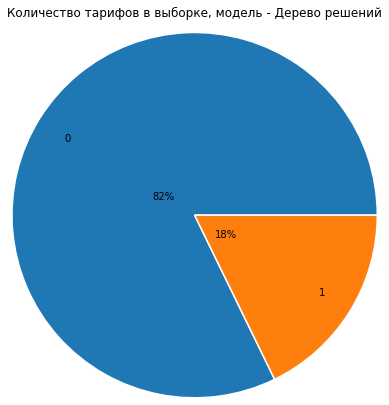

In [36]:
sanity(model_tree.predict(test_x), 'Дерево решений')

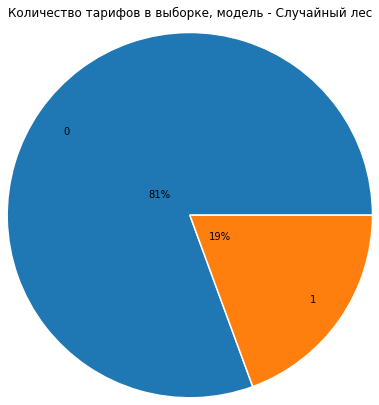

In [37]:
sanity(model_forest.predict(test_x), 'Случайный лес')

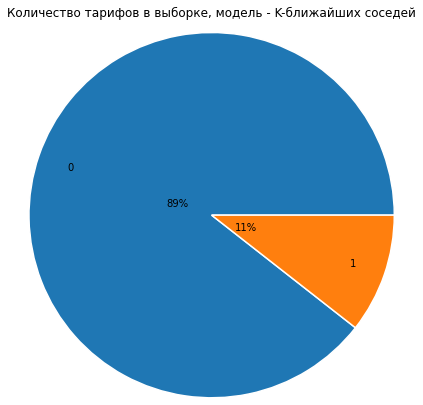

In [38]:
sanity(model_KNeighbors.predict(test_x), 'K-ближайших соседей')

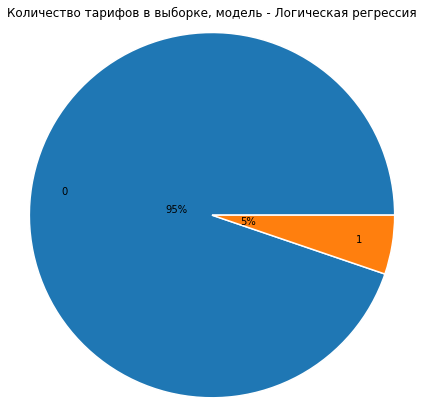

In [39]:
sanity(model_Logistic.predict(test_x), 'Логическая регрессия')

В модели 'Случайный лес' наилучшее сохранение пропорций, хоть и наблюдается частичное смещение ответов в пользу тарифа "Смарт", соотношение тарифов составило 81% на 19%. Для выбранной нами модели 'Дерево решений' соотношение тарифов после итоговой проверки составило 82% к 18%.. Модель "Логическая регрессия" показала наихудщий результат. Почти все ответы она сделала в пользу доминирующего по объему тарифа "Смарт".

## Вывод

В процессе подготовки проекта мы изучили общую информацию по имеющимся у нас данным, изменили тип данных в некоторых столбцах для экономии памяти, а так же проверили отсутствие аномальных значений в признаках. Кроме того мы проверили корреляцию между признаками и выяснили, что между количеством звонков и количеством минут разговора существует высокая зависимость с корреляцией равной 0.98. В связи с этим мы провели эксперимент, в ходе которого выяснилось, что использование обоих признаков и использование лишь одного из них в обучении модели никак не влияет на долю правильных ответов, более того, при использовании лишь одного признака по количеству звонков мизерно увеличивает процент правильных ответов. На основании этого эксперимента было принято решение об удалении из данных информации по количеству минут разговора для предотвращения переобучения моделей и для увеличения скорости предсказаний.

После разделения данных на обучающую и тренировочную выборки и последующее разделение выборок на признаки и целевой признак мы приступили к исследованию моделей и поиску оптимальных гиперпараметров. Мы обучили модели на основе четырех различных классификаторов: Дерево решений, Случайный лес, К-ближайших соседей и Логическая регрессия. Хуже всего проявила себя модель Логическая регрессия. Процент правильных ответов по итогам тестирований у данной модели оказался менее 73%. Кроме того модель Логическая регрессия не прошла проверку на адекватность, все свои ответы она отдала в пользу доминирующего по количеству в выборке тарифа Smart. Модель К-ближайших соседей показала себя порядком лучше при тестировании по сравнению с предыдущей моделью, но все же не достаточно хорошо. Процент правильных ответов при итоговом тестировании достиг 76%, но в пользу тарифа Ultra  данная модель отдала всего 11% (при изначальных 31%), что говорит о ее сомнительной вменяемости. В итоге лучшими моделями оказались Случайный лес и Дерево решений. Они показали примерно одинаковые результаты по итогам кросс-валидации и итоговой проверки на тестовой выборке, а так же при проверке на адекватность. Хоть модель Случайный лес и показала чуть лучший результат, в качестве лучшей модели нами была выбрана модель Дерево решений, так как скорость выполнения предсказания у нее более чем в 10 раз выше, чем у модели Случайный лес.

Рекомендуется использование модели Дерево решений с применением следующих гиперпараметров: минимальное число объектов в листе - 9, число признаков для выбора расщепления - 2, максимальная глубина дерева - 6, критерий - 'entropy'.